# Problem Statement

I have been hired by a cosmetics company who is launching a new brand of haircare and makeup products. They have collected thousands of subreddit posts in order to get people's opinions of similar items, but they forgot to specify which subreddit each post came from. I have been contracted to use other sudbreddit posts to predict which thread each comment belongs to.


# Imports

In [725]:
#imports 
import pandas as pd
import seaborn as sns
import matplotlib as plt

import requests
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Gathering the Data

In [8]:
##function to make a dataset from any sudreddit####

def call_pushshift(subreddit, timestamp = None):
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {
        'subreddit': subreddit,
        'size': 100,
        #'before': created_utc
            }
    if timestamp:
        params['before'] = timestamp
    
    response = requests.get(url,params)
    data = response.json()
    
    dataset= pd.DataFrame(data['data'])
    
    return dataset


### function to get the next set of values and add them to the dataset####

def fetch_subreddit(subreddit):
    dataset = call_pushshift(subreddit)
    for _ in range(6):
        before = dataset['created_utc'].min()
        new_data = call_pushshift(subreddit,before)
        dataset = pd.concat([dataset,new_data], axis = 0)
    dataset['subreddit'] = subreddit 
    return dataset




In [15]:
# Creating the dataset for the first subreddit
makeup = fetch_subreddit('makeupexchange')
makeup.shape

(700, 71)

In [17]:
# Creating the dataset for the second subreddit
haircare = fetch_subreddit('haircareexchange')

In [18]:
haircare.shape

(700, 72)

In [107]:
#creating the full dataset
full_data = pd.concat([makeup,haircare], axis = 0)

In [110]:
full_data.shape

(1400, 79)

# Data Cleaning

In [141]:
full_data.dtypes

all_awardings              object
allow_live_comments        object
author                     object
author_flair_css_class     object
author_flair_richtext      object
                           ...   
steward_reports            object
removed_by                 object
updated_utc               float64
og_description             object
og_title                   object
Length: 79, dtype: object

In [182]:
# Researched each of the columns to see their values and relevance to the 'subreddit column'
full_data.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_css_class',
       'link_flair_richtext', 'link_flair_template_id', 'link_flair_text',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler',
       'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers',
       'subreddit_type', 'suggested_

In [153]:
full_data.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,...,distinguished,edited,crosspost_parent,crosspost_parent_list,url_overridden_by_dest,steward_reports,removed_by,updated_utc,og_description,og_title
0,[],False,yelloweyeshadowz,None,[],None,text,t2_1yj5447j,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,Steccca,Consistent,[],Consistent,text,t2_h0ahq,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,paurelay,Consistent,[],Consistent,text,t2_6m5w7,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,spirit-plant,None,[],None,text,t2_4qs9505z,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,NoAd911,None,[],None,text,t2_boe8omzb,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
#Checked for any missing values
full_data.isnull().sum().sum()

32796

In [578]:
# Narrowed the dataset to columns with values of interest
data = full_data[['subreddit', 'selftext','title','author','domain']]

In [579]:
data.isnull().sum()

subreddit    0
selftext     4
title        0
author       0
domain       0
dtype: int64

In [726]:
data.shape

(1396, 10)

In [580]:
#decided to drop the null values
data = data.dropna()
data.isnull().sum()

subreddit    0
selftext     0
title        0
author       0
domain       0
dtype: int64

# EDA

EDA
Histograms of word count per post for each subreddit
Bar plots of top 20 most frequent words (CountVectorizer) for each subreddit
Bar plots of top 20 TfIdf score words (TfIdfVectorizer + sum) for each subreddit
Analysis of each visualization that includes:
Similarities + differences between subreddits
General themes in topics/meanings of the top words

In [581]:
#Created new columns for the length of the post and the word count of the post
data['posts_length'] = data['selftext'].str.len()
data['word_count'] = data['selftext'].str.split()
data['post_word_count'] = data['word_count'].map(len)

In [582]:
data.head()

,subreddit,selftext,title,author,domain,posts_length,word_count,post_word_count
0,makeupexchange,"\n\n$5 Shipping per item, $8 for bundled item...",[SELL US ONLY] Charlotte Tilbury Blush and Eye...,yelloweyeshadowz,self.makeupexchange,1083,"[$5, Shipping, per, item,, $8, for, bundled, i...",169
1,makeupexchange,\\\* Dibs will be placed on items based on the...,Sell most of the things!,Steccca,self.makeupexchange,2111,"[\\\*, Dibs, will, be, placed, on, items, base...",348
2,makeupexchange,Hi everyone! I can ship the day after payment ...,"[SELL][US] Pat McGrath, Purito, One and Done C...",paurelay,self.makeupexchange,753,"[Hi, everyone!, I, can, ship, the, day, after,...",133
3,makeupexchange,Pay what you want sale! Need everything to go ...,[US] [SELL] NAME YOUR PRICE SALE! NEW ITEMS AD...,spirit-plant,self.makeupexchange,3018,"[Pay, what, you, want, sale!, Need, everything...",343
4,makeupexchange,[removed],Men &amp; fashion,NoAd911,self.makeupexchange,9,[[removed]],1


In [583]:
data['title_count'] = data['title'].str.split()
data['title_word_count'] = data['title_count'].map(len)

In [584]:
data.head()

,subreddit,selftext,title,author,domain,posts_length,word_count,post_word_count,title_count,title_word_count
0,makeupexchange,"\n\n$5 Shipping per item, $8 for bundled item...",[SELL US ONLY] Charlotte Tilbury Blush and Eye...,yelloweyeshadowz,self.makeupexchange,1083,"[$5, Shipping, per, item,, $8, for, bundled, i...",169,"[[SELL, US, ONLY], Charlotte, Tilbury, Blush, ...",46
1,makeupexchange,\\\* Dibs will be placed on items based on the...,Sell most of the things!,Steccca,self.makeupexchange,2111,"[\\\*, Dibs, will, be, placed, on, items, base...",348,"[Sell, most, of, the, things!]",5
2,makeupexchange,Hi everyone! I can ship the day after payment ...,"[SELL][US] Pat McGrath, Purito, One and Done C...",paurelay,self.makeupexchange,753,"[Hi, everyone!, I, can, ship, the, day, after,...",133,"[[SELL][US], Pat, McGrath,, Purito,, One, and,...",16
3,makeupexchange,Pay what you want sale! Need everything to go ...,[US] [SELL] NAME YOUR PRICE SALE! NEW ITEMS AD...,spirit-plant,self.makeupexchange,3018,"[Pay, what, you, want, sale!, Need, everything...",343,"[[US], [SELL], NAME, YOUR, PRICE, SALE!, NEW, ...",30
4,makeupexchange,[removed],Men &amp; fashion,NoAd911,self.makeupexchange,9,[[removed]],1,"[Men, &amp;, fashion]",3


In [585]:
data.shape

(1396, 10)

In [586]:
#number of different authors
data['author'].nunique()

877

In [587]:
#authors with the most posts
data['author'].value_counts().nlargest(10)

abbythestabby           16
Secretdisneyprincess    13
jimmisen                12
mezamm                  11
mishbooger              11
chiquitadiva            11
[deleted]                9
DitaVonChaos             9
pandasparkle             8
momspaghettysburg        7
Name: author, dtype: int64

In [588]:
# The 10 longest longest posts in the data
data['post_word_count'].nlargest(10)

21    5956
24    5346
11    4911
46    3699
58    2589
45    2483
66    2401
96    2229
11    2206
55    2176
Name: post_word_count, dtype: int64

In [589]:
#Average word count in each post 
data['post_word_count'].mean()

207.94914040114614

In [590]:
#Range for the word counts per post
print(data['post_word_count'].min())
print(data['post_word_count'].max())

0
5956


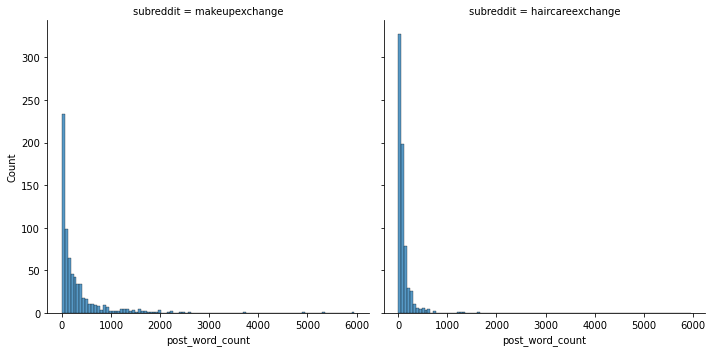

In [591]:
# Plot of the word counts per post by subreddit
sns.displot(data = data, x = 'post_word_count', col = 'subreddit', bins = 100 );

In [543]:
#Average word count in each title
data['title_word_count'].mean()

11.41189111747851

In [540]:
#Range for the word count in the titles
print(data['title_word_count'].min())
print(data['title_word_count'].max())

1
53


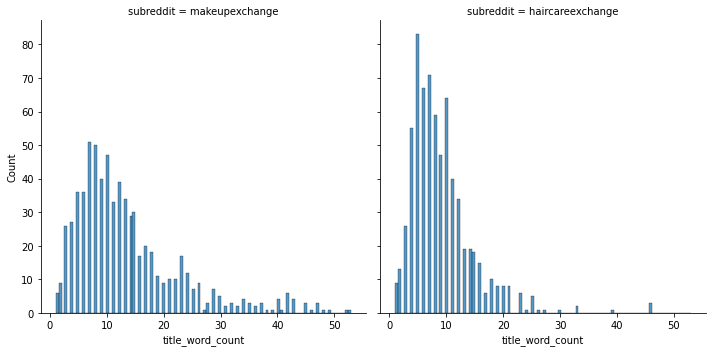

In [530]:
# Plot of the word counts per title by subreddit
sns.displot(data = data, x = 'title_word_count', col = 'subreddit', bins = 100 );

The word counts were examined both by post and by title in order to decide which column would be a better predictor for the model. The word count by post was very right skewed showing that there were many posts which were shorter and much less that were longer. The word count by title showed a much more normal distribution for each subreddit signifying that the titles contained a vairety of different lengths. This shows me that the title column would most likely be a better predictor, but because we want to predict based on post, the model will use the posts as the predictor. 

# Modeling

In [665]:
# Set variables and created a training set with 75% of the data and a testing set with 25% of the data
# Decided to use the 'selftext' column as the main predictor
X = data['selftext']
y = data['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [666]:
#Baseline Accuracy
y.value_counts(normalize=True)

haircareexchange    0.501433
makeupexchange      0.498567
Name: subreddit, dtype: float64

In [705]:
#decided to remove the Stop words
# Instantiated a CountVectorizer,Fit the count vectorizer on the posts, 
#transformed the data and converted to a dataframe
cv = CountVectorizer(stop_words = 'english')
vec_words = cv.fit_transform(X_train)
vec_words_df = pd.DataFrame(vec_words.todense(), columns=cv.get_feature_names())

In [697]:
vec_words_df

,00,0008,001,0018oz,002,003,0035,0035oz,00383mp,004,...,zy9ghrt,zyd684m,zyf4efx,zylknjq,zymqqny,zyo9ccm,zyu4qia,zyuigwg,zzkagmh,zzpgkdt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1043,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [669]:
vec_words_df['subreddit'] = y_train.values

In [670]:
vec_words_df.dtypes

00         int64
0008       int64
001        int64
0018oz     int64
002        int64
           ...  
zyo9ccm    int64
zyu4qia    int64
zyuigwg    int64
zzkagmh    int64
zzpgkdt    int64
Length: 14267, dtype: object

In [703]:
#Top 20 occurring words in the count vectorizer
vec_words_df.sum().sort_values(ascending = False).head(20)

com         5846
imgur       5700
https       5601
used        2591
oz          2278
amp         2157
new         1787
bn          1450
10          1392
shipping    1069
lip         1045
palette     1017
jpg          918
bnib         892
swatched     851
15           844
beauty       826
free         774
lipstick     754
mini         711
dtype: int64

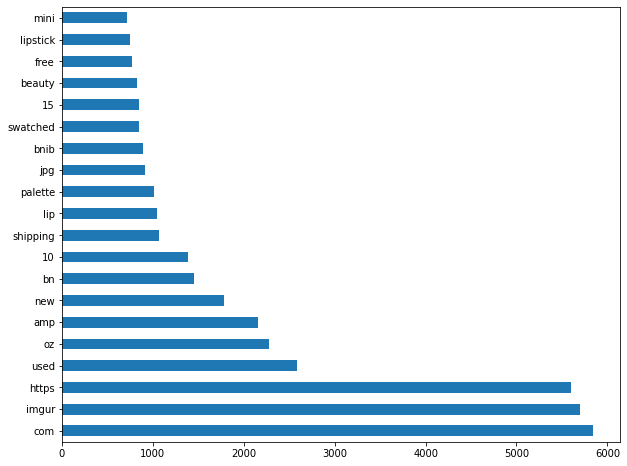

In [704]:
#plot of the top 20 most occuring words
vec_words_df.sum().sort_values(ascending = False).head(20).plot(kind='barh', figsize =(10,8));

For the count vectorizer most of the top occurring words can pertain to both 

In [674]:
#decided to remove the Stop words
# Instantiated a TfidfVectorizer, it on the posts, 
#transformed the data and converted to a dataframe

tifidif = TfidfVectorizer(stop_words = 'english')

tf_words = tifidif.fit_transform(X_train) 
tf_words_df = pd.DataFrame(tf_words.todense(), columns=cv.get_feature_names())

In [675]:
#Top 20 most occuring words in the tfidf model
tf_words_df.sum().sort_values(ascending=False).head(20)

removed        89.183704
com            64.178389
https          63.750286
imgur          63.040564
used           51.020819
new            35.416564
amp            33.195631
oz             31.901387
shipping       30.651971
hair           27.938439
palette        25.078533
10             23.257519
bn             22.559245
products       22.394831
jpg            22.276993
looking        21.855694
conditioner    20.551428
free           19.898478
shampoo        18.571710
just           17.486150
dtype: float64

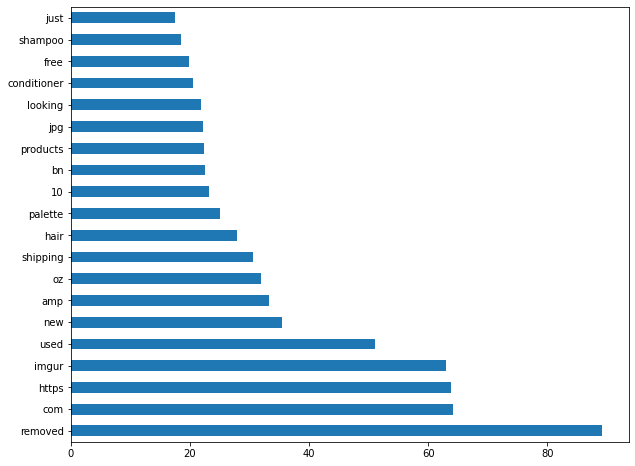

In [676]:
# plot of the top 20 most occuring words in the tfid model
tf_words_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', figsize =(10,8));

# Comparing Models

In [677]:
# Getting the baseline accuracy
y_train.value_counts(normalize=True)

haircareexchange    0.501433
makeupexchange      0.498567
Name: subreddit, dtype: float64

In [736]:
#Created and tested my first model
pipe1 = Pipeline([
    ('cv', CountVectorizer(min_df=2, stop_words = 'english')),
    ('lr', LogisticRegressionCV(solver='liblinear'))
])

pipe1.fit(X_train, y_train)
pipe1.score(X_train, y_train), pipe1.score(X_test, y_test)

(0.9684813753581661, 0.9598853868194842)

In [727]:
#Created and tested my second model
pipe2 = Pipeline([
    ('cv', CountVectorizer(min_df=2, stop_words = 'english')),
    ('mnb', MultinomialNB())
])

pipe2.fit(X_train, y_train)
pipe2.score(X_train, y_train), pipe2.score(X_test, y_test)

(0.8939828080229226, 0.8882521489971347)

In [732]:
#Created and tested my third model
##BEST MODEL
pipe3 = Pipeline([
    ('tf', TfidfVectorizer(min_df=1, stop_words = 'english')),
    ('lr', LogisticRegressionCV(solver='liblinear'))
])

pipe3.fit(X_train, y_train)
pipe3.score(X_train, y_train), pipe3.score(X_test, y_test)

(0.9732569245463228, 0.9598853868194842)

In [735]:
#Created and tested my fourth model
pipe4 = Pipeline([
    ('tf', TfidfVectorizer(min_df=2, stop_words = 'english')),
    ('mnb', MultinomialNB())
])

pipe4.fit(X_train, y_train)
pipe4.score(X_train, y_train), pipe4.score(X_test, y_test)

(0.9570200573065902, 0.9598853868194842)

# BEST MODEL


In [682]:
# Got the average score across three folds
cross_val_score(pipe3, X_train, y_train, cv=3).mean() 

0.9283667621776505

In [683]:
pipe3 = Pipeline([
    ('tf', TfidfVectorizer(min_df=1)),
    ('lr', LogisticRegressionCV(solver='liblinear'))
])

pipe3.fit(X_train, y_train)
pipe3.score(X_train, y_train), pipe3.score(X_test, y_test)

(0.9732569245463228, 0.9512893982808023)

In [684]:
#Grid Search to find the best parameters
pipe3_params = {
  "tf__max_features": [2000, 3000, 4000, 5000],
  "tf__stop_words": [None, "english"],
  "tf__ngram_range": [(1,1), (1, 2)]
}

gs_tifidif = GridSearchCV(
  pipe3,
  param_grid=pipe3_params,
  cv=5,
  verbose=1
)

In [685]:
#Fit the gridSearch model to the data
gs_tifidif.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tf__max_features': [2000, 3000, 4000, 5000],
                         'tf__ngram_range': [(1, 1), (1, 2)],
                         'tf__stop_words': [None, 'english']},
             verbose=1)

In [738]:
cross_val_score(gs_tifidif, X_train, y_train, cv=3).mean() 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   49.6s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   46.5s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   52.7s finished


0.9226361031518625

In [686]:
#Caluculated the best score
gs_tifidif.best_score_

0.932157666894509

In [687]:
#Got the best parameters for the model
gs_tifidif.best_params_

{'tf__max_features': 4000,
 'tf__ngram_range': (1, 2),
 'tf__stop_words': 'english'}

In [688]:
#Got the GridSearch Score on the training data
gs_tifidif.score(X_train, y_train)

0.9656160458452722

In [689]:
#Got the GridSearch Score on the testing data
gs_tifidif.score(X_test,y_test)

0.9426934097421203

This model performed the best on both the testing and training sets 

# Evaluation and Interpretation

Use accuracy, sensitivity, and specificity to decide on a winner from the four pipelines
For the winning pipeline:
Visualize the most important coefficients
Discuss any common themes in the most important features

In [690]:
#Made a dataframe to show the words and their importance to the model
tifidif_dict = {
    'words': tifidif.get_feature_names(),
    'idf': tifidif.idf_
}

tifidif_dict_df = pd.DataFrame(tifidif_dict)

In [739]:
#term frequency inverse: Which words mean the most to the model
tifidif_dict_df.sort_values(by='idf', ascending=False).head(10)

,words,idf
7133,khvpoka,7.261492
8209,menageriecosmetics,7.261492
7768,lovers,7.261492
7770,lovesick,7.261492
7772,lovin,7.261492
7775,lowball,7.261492
7777,lowered,7.261492
7780,lp,7.261492
7781,lpi6ser,7.261492
7782,lq7xvmc,7.261492


In [692]:
# Got the predictions and the confusion matrix values
tifidif_preds = gs_tifidif.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, tifidif_preds).ravel()


In [707]:
# Calculated the specificity and sensitivity. Spec = true neg, Sen = true pos
print("Specificity (True Negative) : ", tn / (tn + fp))
print("Sensitivity (True Positive) : ", tp / (tp+fn))

Specificity (True Negative) :  0.9542857142857143
Sensitivity (True Positive) :  0.9310344827586207


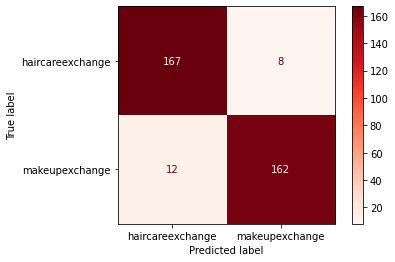

In [694]:
#Plot of the confusion matrix of the values for the tesing data
plot_confusion_matrix(gs_tifidif, X_test, y_test, cmap="Reds");

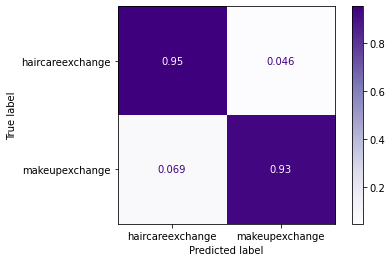

In [748]:
#Plot of the confusion matrix of the proportion of the values for the testing data
plot_confusion_matrix(gs_tifidif, X_test, y_test, cmap="Purples", normalize="true");

# Conclusions and Recommendations 

The model performed fairly well, but could potentially be improved by
- Incorporating the “title” column into to predictor
- Experimenting with more parameters and hyperparameters
- Pickling the model so that it can be used by the common client 
